<h1 style="font-size:60px;"> <center> TABULAR NOTEBOOK BLUEPRINT </center> </h1>

In [20]:
import datetime as dt
import os
import signal
import sys
import time
import warnings
from dataclasses import dataclass

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import pandas as pd

# import shap
from catboost import CatBoostClassifier
from dataprep.eda import create_report
from fastai.tabular.core import df_shrink
from IPython.display import clear_output
from lightgbm import LGBMClassifier
from optuna.integration import (
    CatBoostPruningCallback,
    LightGBMPruningCallback,
    XGBoostPruningCallback,
)
from scipy.stats import mode
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    PolynomialFeatures,
)
from tpot import TPOTClassifier
from xgboost import DMatrix, XGBClassifier, cv, plot_importance

<h1 style="font-size:50px;"> <center> CONSTANTS & CONFIGURATION</center> </h1>

In [4]:
@dataclass
class C:
    RANDOM_SEED = 42
    KFOLD_SPLIT = 5
    EVAL_METRIC = "accuracy"
    HO_TRIAL = 2
    USE_HISTGBM: = True
    USE_LIGHTGBM = True
    USE_XGBOOST = True
    USE_CATBOOST = True

In [5]:
# init_datatables_mode()
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [6]:
warnings.filterwarnings("ignore")

In [7]:
sys.path.append("../logger")
import logger

log = logger.setup_applevel_logger(
    file_name="classification blueprint.log",
)

<h1 style="font-size:50px;"> <center> READ DATA </center> </h1>

In [8]:
train_org = pd.read_csv("../input/train.csv", delimiter=",")
train_org

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [9]:
test_org = pd.read_csv("../input/test.csv", delimiter=",")
test_org

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


<h1 style="font-size:50px;"> <center> EDA </center> </h1>

<h1 style="font-size:40px;"> <center>  Adversarial Validation  </center> </h1>

In [21]:
# select only the numerical features
X_test = test_org.select_dtypes(include=["number"]).copy()
X_train = train_org.select_dtypes(include=["number"]).copy()

# drop the target column from the training data
X_train = X_train.drop(["Survived"], axis=1)

# add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"] = 1

# make one big dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(["AV_label"], axis=1)
y = all_data_shuffled["AV_label"]
XGBdata = DMatrix(data=X, label=y)

# our XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.05,
    "max_depth": 5,
}

# perform cross validation with XGBoost
cross_val_results = cv(
    dtrain=XGBdata,
    params=params,
    nfold=5,
    metrics="auc",
    num_boost_round=200,
    early_stopping_rounds=20,
    as_pandas=True,
)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

0    0.999471
Name: test-auc-mean, dtype: float64


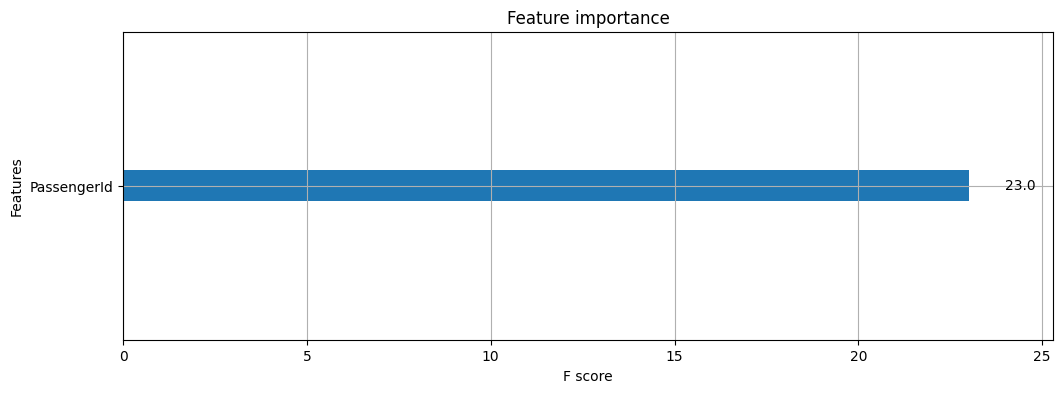

In [22]:
classifier = XGBClassifier(
    eval_metric="logloss", use_label_encoder=False
)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(12, 4))
plot_importance(classifier, ax=ax)
plt.show();

In [23]:
X = X.drop(["PassengerId"], axis=1)

In [24]:
XGBdata = DMatrix(data=X, label=y)
cross_val_results = cv(
    dtrain=XGBdata,
    params=params,
    nfold=5,
    metrics="auc",
    num_boost_round=200,
    early_stopping_rounds=20,
    as_pandas=True,
)

print((cross_val_results["test-auc-mean"]).tail(1))

29    0.531164
Name: test-auc-mean, dtype: float64


<h1 style="font-size:40px;"> <center>  Data Prep  </center> </h1>

In [6]:
report = create_report(train, title="Titanic Data")
report.save("../Reports/Titanic Data Report")

  0%|                                                                                         | 0/1420 [00:00<…

invalid value encountered in divide
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<h1 style="font-size:50px;"> <center> FEATURE ENGINEERING </center> </h1>

<h1 style="font-size:40px;"> <center> OPTIMIZE THE SPACE </center> </h1>

In [ ]:
print(
    f"{train_org.memory_usage().sum()/(1024**2)} MB is used before df_shrink"
)
train = df_shrink(train_org, int2uint=True)
print(
    f"{train.memory_usage().sum()/(1024**2)} MB is used after df_shrink"
)

In [ ]:
print(
    f"{test_org.memory_usage().sum()/(1024**2)} MB is used before df_shrink"
)
test = df_shrink(train_org, int2uint=True)
print(
    f"{test.memory_usage().sum()/(1024**2)} MB is used after df_shrink"
)

<h1 style="font-size:40px;"> <center> DATETIME CONVERSIONS </center> </h1>

In [ ]:
# demo.columns = [column.strip() for column in demo.columns]
# demo['Log'] = pd.to_datetime(demo['Log'], format='%d.%m.%Y %H:%M')
# demo['Establishment_Date (Y-M)'] = demo['Establishment_Date'].dt.strftime('%Y.%m')
# finance['Age'] = (dt.datetime.now() - pd.to_datetime(finance['Establishment_Date (Y-M)'])).astype('<m8[Y]')
# finance["Financial Report Date (Y-M)"] = finance["FINANCIAL_YEAR"].astype(str) + "." + finance["FINANCIAL_MONTH"].astype(str)

<h1 style="font-size:40px;"> <center> GROUPBY & AGGREGATION</center> </h1>

In [2]:
# def flatten_cols(df):
#    df.columns = ['_'.join(x) for x in df.columns.to_flat_index()]
#    return df.reset_index()

# username_agg_df = (
#    tweets_df
#    .groupby(["username"])                 # Group by username
#    .agg({"text": "count",                 # Count tweets per username
#         "text_length": "mean",           # Average tweet length per username
#          "created_at": ["sum", "min", "median", "max", "mean", "std", "quantile([0.25,0.75])"]})   # Min and max date per username
#    .pipe(flatten_cols)                    # Apply flatten_cols() to entire df
# )

<h1 style="font-size:40px;"> <center> MERGE & SORTING </center> </h1>

In [ ]:
# merged_data = pd.merge(finance, risk, how = "left", on='Customer_num')
# demo.sort_values(by=['Customer_num', "Log (Y-M)"], inplace=True)

<h1 style="font-size:40px;"> <center> IMPUTING </center> </h1>

In [ ]:
imp_mean = SimpleImputer(missing_values=pd.NA, strategy="mean")
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

<h1 style="font-size:40px;"> <center> GENERATING POLYNOMIAL FEATURES </center> </h1>

In [ ]:
poly = PolynomialFeatures(3)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

<h1 style="font-size:40px;"> <center> DROP COLUMNS & LABEL ENCODING & SCALING </center> </h1>

In [16]:
X_train_org = train.drop(
    ["PassengerId", "Name", "Ticket", "Cabin", "Survived"], axis=1
)
y_train_org = train["Survived"]
X_test = test.drop(
    ["PassengerId", "Name", "Ticket", "Cabin", "Survived"], axis=1
)
# priceData.rename(columns={"Validfrom": "Date", "City Code": "CityCode"}, inplace=True)

In [18]:
cat_cols = [
    col
    for col in X_train_org.columns
    if X_train_org[col].dtype in ["O", "category"]
]
num_cols = [col for col in X_train_org.columns if col not in cat_cols]

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_org,
    y_train_org,
    test_size=0.3,
    random_state=C.RANDOM_SEED,
    stratify=y_train_org,
)

In [21]:
le = LabelEncoder()
for cat_col in cat_cols:
    X_train[cat_col] = le.fit_transform(X_train[cat_col])
    X_val[cat_col] = le.transform(X_val[cat_col])
    X_test[cat_col] = le.transform(X_test[cat_col])

In [22]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

<h1 style="font-size:40px;"> <center> SAVE PREPROCESSED DATA </center> </h1>

In [ ]:
X_train.to_csv("../input/train.csv")
X_test.to_csv("../input/test.csv")

<h1 style="font-size:40px;"> <center> Mlflow Setup  </center> </h1>

In [10]:
try:
    experiment_id = mlflow.create_experiment("Classification with ML")
    experiment = mlflow.get_experiment(experiment_id)
except:
    experiment = mlflow.get_experiment_by_name("Classification with ML")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

print(f"Name: {experiment.name}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")
print(f"Experiment ID: {experiment.experiment_id}")

Name: Classification with ML
Artifact Location: file:///C:/Users/NEO/Desktop/Kaggle/Kaggle-Blueprints/Classification%20Blueprint%20with%20ML/mlruns/272633739088592373
Lifecycle_stage: active
Experiment ID: 272633739088592373


<h1 style="font-size:60px;"> <center> MACHINE LEARNING </center> </h1>

<h1 style="font-size:50px;"> <center> Modeling </center> </h1>

<h1 style="font-size:40px;"> <center> Hist GBM </center> </h1>

In [ ]:
if C.USE_HISTGBM:
    with mlflow.start_run(
        experiment_id=experiment.experiment_id,
        run_name="HistGBM Base Model",
    ) as run:
        clf = HistGradientBoostingClassifier()
        cv = StratifiedKFold(
            n_splits=C.KFOLD_SPLIT,
            shuffle=True,
            random_state=C.RANDOM_SEED,
        )
        scores = cross_val_score(
            clf, X_train, y_train, cv=cv, scoring=C.EVAL_METRIC
        )
        log.info(f"{np.mean(scores) = }")
        mlflow.log_metric(f"{C.EVAL_METRIC}", np.mean(scores))

<h1 style="font-size:40px;"> <center> Light GBM </center> </h1>

In [12]:
if C.USE_LIGHTGBM:
    with mlflow.start_run(
        experiment_id=experiment.experiment_id,
        run_name="LightGBM Base Model",
    ) as run:
        clf = LGBMClassifier()
        cv = StratifiedKFold(
            n_splits=C.KFOLD_SPLIT,
            shuffle=True,
            random_state=C.RANDOM_SEED,
        )
        scores = cross_val_score(
            clf, X_train, y_train, cv=cv, scoring=C.EVAL_METRIC
        )
        log.info(f"{np.mean(scores) = }")
        mlflow.log_metric(f"{C.EVAL_METRIC}", np.mean(scores))

2023-03-13 15:13:42,466[:19] - MyApp - INFO - np.mean(scores) = 0.7993419354838709


np.mean(scores) = 0.7993419354838709


In [ ]:
clf = LGBMClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_val, clf.predict(X_val)))

<h1 style="font-size:40px;"> <center> XGBoost </center> </h1>

In [13]:
if C.USE_XGBOOST:
    with mlflow.start_run(
        experiment_id=experiment.experiment_id,
        run_name="XGBoost Base Model",
    ) as run:
        clf = XGBClassifier()
        cv = StratifiedKFold(
            n_splits=C.KFOLD_SPLIT,
            shuffle=True,
            random_state=C.RANDOM_SEED,
        )
        scores = cross_val_score(
            clf, X_train, y_train, cv=cv, scoring=C.EVAL_METRIC
        )
        log.info(f"{np.mean(scores) = }")
        mlflow.log_metric(f"{C.EVAL_METRIC}", np.mean(scores))

0.8025677419354839


In [ ]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_val, clf.predict(X_val)))

<h1 style="font-size:40px;"> <center> CatBoost </center> </h1>

In [15]:
if C.USE_CATBOOST:
    with mlflow.start_run(
        experiment_id=experiment.experiment_id,
        run_name="CatBoost Base Model",
    ) as run:
        clf = CatBoostClassifier(verbose=0)
        cv = StratifiedKFold(
            n_splits=C.KFOLD_SPLIT,
            shuffle=True,
            random_state=C.RANDOM_SEED,
        )
        scores = cross_val_score(
            clf, X_train, y_train, cv=cv, scoring=C.EVAL_METRIC
        )
        log.info(f"{np.mean(scores) = }")
        mlflow.log_metric(f"{C.EVAL_METRIC}", np.mean(scores))

0.8169806451612903


In [ ]:
clf = CatBoostClassifier(verbose=0)
clf.fit(X_train, y_train)
print(classification_report(y_val, clf.predict(X_val)))

<h1 style="font-size:40px;"> <center> TPOT </center> </h1>

In [23]:
tpot = TPOTClassifier(
    generations=5,
    population_size=50,
    verbosity=2,
    random_state=C.RANDOM_SEED,
)
tpot.fit(X_train, y_train)
print(tpot.score(X_val, y_val))
tpot.export("tpot_pipeline.py")

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8281935483870967

Generation 2 - Current best internal CV score: 0.8281935483870967

Generation 3 - Current best internal CV score: 0.8281935483870967

Generation 4 - Current best internal CV score: 0.8281935483870967

Generation 5 - Current best internal CV score: 0.8281935483870967

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=10, min_samples_split=8, n_estimators=100, subsample=0.25)
Imputing missing values in feature set
0.8097014925373134


<h1 style="font-size:50px;"> <center> Hyperparameter Tuning </center> </h1>

In [ ]:
best_hps = {}

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(
    X_train, y_train, test_size=0.30, random_state=C.RANDOM_SEED
)

<h1 style="font-size:40px;"> <center> Hist GBM </center> </h1>

In [ ]:
%%notify
if C.USE_HISTGBM:
    with mlflow.start_run(
        experiment_id=experiment.experiment_id, run_name="HistGBM HO"
    ) as run:

        def objective(trial):
            params = {
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),   
                'max_iter': trial.suggest_int('max_iter', 10, 10_000),
                'max_depth': trial.suggest_int('max_depth', 2, 12),           
                'min_samples_leaf': trial.suggest_int('min_data_in_leaf', 2, 300),
                'l2_regularization': trial.suggest_float('reg_lambda', 0, 100.0),
                'max_bins': trial.suggest_int('max_bin', 32, 512),
                }

            clf = HistGradientBoostingClassifier(
                random_state=C.RANDOM_SEED,
                **params
            )
            
            fit_params={
                'verbose': False,
                'eval_set': [[val_x, val_y]],
                       }
            cv = StratifiedKFold(
                n_splits=C.KFOLD_SPLIT, shuffle=True, random_state=C.RANDOM_SEED
            )
            scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=C.EVAL_METRIC,
                                    fit_params=fit_params)
            clear_output(wait=True)
            return np.mean(scores)

        
        sampler = optuna.samplers.TPESampler(seed=C.RANDOM_SEED)
        pruner=optuna.pruners.SuccessiveHalvingPruner()
        study = optuna.create_study(
            direction="maximize",
            study_name="HistGBM Classification",
            sampler=sampler,
            pruner=pruner,
        )
        study.optimize(objective, n_trials=C.HO_TRIAL, gc_after_trial=True)
        
        best_trial = study.best_trial
        log.info(f"Best {C.EVAL_METRIC}: {best_trial.value}")
        log.info(f"Best hyperparameters: {best_trial.params}")
        best_hps["histgbm"] = best_trial.params
        for key in best_trial.params.keys():
            mlflow.log_param(f"{key}", best_trial.params[key])
        mlflow.log_metric(f"{C.EVAL_METRIC}", best_trial.value)

<h1 style="font-size:40px;"> <center> Light GBM </center> </h1>

In [13]:
%%notify
if C.USE_LIGHTGBM:
    with mlflow.start_run(
        experiment_id=experiment.experiment_id, run_name="LightGBM HO"
    ) as run:

        def objective(trial):
            params = {
                    'n_estimators': trial.suggest_int('n_estimators', 10, 10_000),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),    
                    'max_depth': trial.suggest_int('max_depth', 1, 16),           
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 0, 300),
                    'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
                    'max_bin': trial.suggest_int('max_bin', 32, 512),
                    'subsample': trial.suggest_float('subsample', 0.01, 1.0),
                    'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
                    'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
                    'subsample_for_bin': trial.suggest_int('subsample_for_bin', 30, 1000),
                    'reg_lambda': trial.suggest_loguniform('reg_lambda', 0, 100.0),
                    'reg_alpha': trial.suggest_loguniform('reg_alpha', 0, 100.0),
                    'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1e-6, 500.0),
                }
            params['num_leaves'] = trial.suggest_int('num_leaves', 2, 2**params['max_depth']),

            clf = LGBMClassifier(
                random_state=C.RANDOM_SEED,
                **params
            )
            
            pruning_callback = LightGBMPruningCallback(trial, 'validation_0-' + C.EVAL_METRIC)
            fit_params={
                'callbacks':[pruning_callback],
                'verbose': False,
                'early_stopping_rounds': params["n_estimators"]//10, 
                'eval_set': [[val_x, val_y]],
                       }
            cv = StratifiedKFold(
                n_splits=C.KFOLD_SPLIT, shuffle=True, random_state=C.RANDOM_SEED
            )
            scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=C.EVAL_METRIC,
                                    fit_params=fit_params)
            clear_output(wait=True)
            return np.mean(scores)

        
        sampler = optuna.samplers.TPESampler(seed=C.RANDOM_SEED)
        pruner=optuna.pruners.SuccessiveHalvingPruner()
        study = optuna.create_study(
            direction="maximize",
            study_name="LightGBM Classification",
            sampler=sampler,
            pruner=pruner,
        )
        study.optimize(objective, n_trials=C.HO_TRIAL, gc_after_trial=True)
        best_trial = study.best_trial
        log.info(f"Best {C.EVAL_METRIC}: {best_trial.value}")
        log.info(f"Best hyperparameters: {best_trial.params}")
        best_hps["lightgbm"] = best_trial.params
        for key in best_trial.params.keys():
            mlflow.log_param(f"{key}", best_trial.params[key])
        mlflow.log_metric(f"{C.EVAL_METRIC}", best_trial.value)

[I 2023-03-13 15:15:11,049] Trial 0 finished with value: 0.6340645161290323 and parameters: {'num_leaves': 4371, 'reg_alpha': 6.351221010640703, 'reg_lambda': 0.8471801418819978, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'min_child_samples': 60, 'min_data_per_groups': 52, 'scale_pos_weight': 7}. Best is trial 0 with value: 0.6340645161290323.


2023-03-13 15:15:11,065[:19] - MyApp - INFO - Best C.METRIC = 'accuracy' 0.6340645161290323


Best C.METRIC = 'accuracy' 0.6340645161290323


2023-03-13 15:15:11,065[:19] - MyApp - INFO - Best hyperparameters: {'num_leaves': 4371, 'reg_alpha': 6.351221010640703, 'reg_lambda': 0.8471801418819978, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'min_child_samples': 60, 'min_data_per_groups': 52, 'scale_pos_weight': 7}


Best hyperparameters: {'num_leaves': 4371, 'reg_alpha': 6.351221010640703, 'reg_lambda': 0.8471801418819978, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'min_child_samples': 60, 'min_data_per_groups': 52, 'scale_pos_weight': 7}


<IPython.core.display.Javascript object>

<h1 style="font-size:40px;"> <center> XGBoost </center> </h1>

In [11]:
%%notify
if C.USE_XGBOOST:
    with mlflow.start_run(
        experiment_id=experiment.experiment_id, run_name="XGBoost HO"
    ) as run:

        def objective(trial):
            params = {
                    'n_estimators': trial.suggest_int('n_estimators', 10, 5000),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                    'max_depth': trial.suggest_int('max_depth', 1, 50),
                    'max_delta_step': trial.suggest_int('max_delta_step', 0, 20),
                    'subsample': trial.suggest_float('subsample', 0.1, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
                    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 100.0),
                    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 100.0),
                    'gamma': trial.suggest_loguniform('gamma', 1e-9, 0.5),
                    'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1e-6, 500.0),
                }

            clf = XGBClassifier(
                random_state=C.RANDOM_SEED,
                tree_method="gpu_hist",
                predictor="gpu_predictor",
                eval_metric=C.EVAL_METRIC
                **params)
            
            pruning_callback = XGBoostPruningCallback(trial, 'validation_0-' + C.EVAL_METRIC)
            fit_params={
                'callbacks':[pruning_callback],
                'verbose': False,
                'early_stopping_rounds': params["n_estimators"]//10, 
                'eval_set': [[val_x, val_y]],
                       }
            
            cv = StratifiedKFold(
                n_splits=C.KFOLD_SPLIT, shuffle=True, random_state=C.RANDOM_SEED
            )   
            scores = cross_val_score(clf, train_x, train_y, cv=cv, scoring=C.EVAL_METRIC, 
                                     fit_params=fit_params)
            clear_output(wait=True)
            return np.mean(scores)

        sampler = optuna.samplers.TPESampler(seed=C.RANDOM_SEED)
        pruner=optuna.pruners.SuccessiveHalvingPruner()
        study = optuna.create_study(
            direction="maximize",
            study_name="XGBoost Classification",
            sampler=sampler,
            pruner=pruner,
        )
        study.optimize(objective, n_trials=C.HO_TRIAL, gc_after_trial=True)
        best_trial = study.best_trial
        log.info(f"Best {C.EVAL_METRIC = }: {best_trial.value}")
        log.info(f"Best hyperparameters: {best_trial.params}")
        best_hps["xgboost"] = best_trial.params
        for key in best_trial.params.keys():
            mlflow.log_param(f"{key}", best_trial.params[key])
        mlflow.log_metric(f"{C.EVAL_METRIC}", best_trial.value)

[I 2023-03-01 13:00:45,374] A new study created in memory with name: XGBoost Classification
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See ht

Best accuracy: 0.5523354838709678
Best hyperparameters: {'max_depth': 1, 'learning_rate': 0.8706020878304853, 'n_estimators': 425, 'min_child_weight': 3, 'gamma': 2.8483918709107956e-07, 'subsample': 0.023270677083837805, 'colsample_bytree': 0.04059611610484305, 'reg_alpha': 0.00015777981883364995, 'reg_lambda': 2.85469785779718e-05, 'scale_pos_weight': 5}


<h1 style="font-size:40px;"> <center> CatBoost </center> </h1>

In [12]:
%%notify
if C.USE_CATBOOST:
    with mlflow.start_run(
        experiment_id=experiment.experiment_id, run_name="CatBoost HO"
    ) as run:

        def objective(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 10, 1000),
                'depth': trial.suggest_int('depth', 1, 8),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
                'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10.0),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'border_count': trial.suggest_int('border_count', 1, 255),
                
                'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30),
                'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 0.01, 10.0),

            }
            
            clf = CatBoostClassifier(
                random_state=C.RANDOM_SEED,
                eval_metric='AUC',
                verbose=0,
                **params, )
            
            pruning_callback = CatBoostPruningCallback(trial, 'validation_0-' + C.EVAL_METRIC)
            fit_params={
                'callbacks':[pruning_callback],
                'verbose': False,
                'early_stopping_rounds': params["n_estimators"]//10, 
                'eval_set': [[val_x, val_y]],
                       }        
            
            cv = StratifiedKFold(
                n_splits=C.KFOLD_SPLIT, shuffle=True, random_state=C.RANDOM_SEED
            )
            scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=C.EVAL_METRIC
                                      fit_params=fit_params)
            
            clear_output(wait=True)
            return np.mean(scores)
        
        
        sampler = optuna.samplers.TPESampler(seed=C.RANDOM_SEED)
        pruner=optuna.pruners.SuccessiveHalvingPruner()
        study = optuna.create_study(
            direction="maximize",
            study_name="Catboost Classification",
            sampler=sampler,
            pruner=pruner,
        )
        study.optimize(objective, n_trials=C.HO_TRIAL)
        
        best_trial = study.best_trial
        log.info(f"Best {C.EVAL_METRIC}: {best_trial.value}")
        log.info(f"Best hyperparameters: {best_trial.params}")
        best_hps["catboost"] = best_trial.params
        for key in best_trial.params.keys():
            mlflow.log_param(f"{key}", best_trial.params[key])
        mlflow.log_metric(f"{C.EVAL_METRIC}", best_trial.value)

[I 2023-03-01 13:01:18,750] A new study created in memory with name: Catboost Classification
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-03-01 13:01:31,928] Trial 0 finished with value: 0.7383483870967742 and parameters: {'iterations': 2185, 'learning_rate': 0.7969454818643931, 'l2_leaf_reg': 29.10635913133069, 'bagging_temperature': 2.385234757844707, 'random_strength': 1.1560186404424364, 'depth': 2, 'min_data_in_leaf': 1

Best accuracy: 0.7752516129032259
Best hyperparameters: {'iterations': 3205, 'learning_rate': 0.2607024758370766, 'l2_leaf_reg': 1.0994335574766196, 'bagging_temperature': 17.052641538983092, 'random_strength': 1.8324426408004217, 'depth': 3, 'min_data_in_leaf': 55, 'scale_pos_weight': 4}


<h1 style="font-size:50px;"> <center> Feature Importance </center> </h1>

In [25]:
le = LabelEncoder()
for cat_col in cat_cols:
    X[cat_col] = le.fit_transform(X[cat_col])

<h1 style="font-size:40px;"> <center> XGBoost </center> </h1>

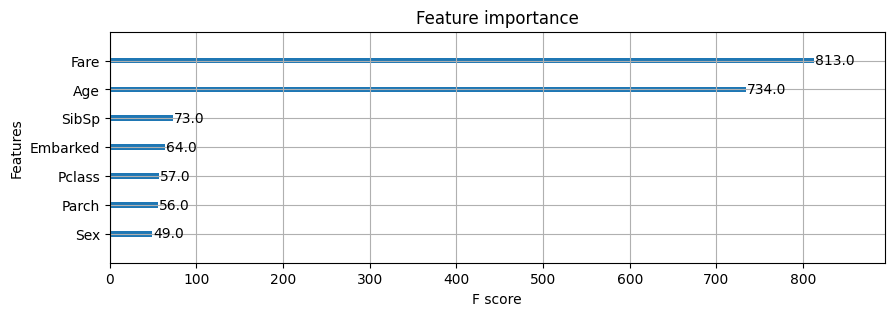

In [26]:
clf = XGBClassifier()
clf.fit(X, y)
plt.rcParams["figure.figsize"] = (10, 3)
plot_importance(clf)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


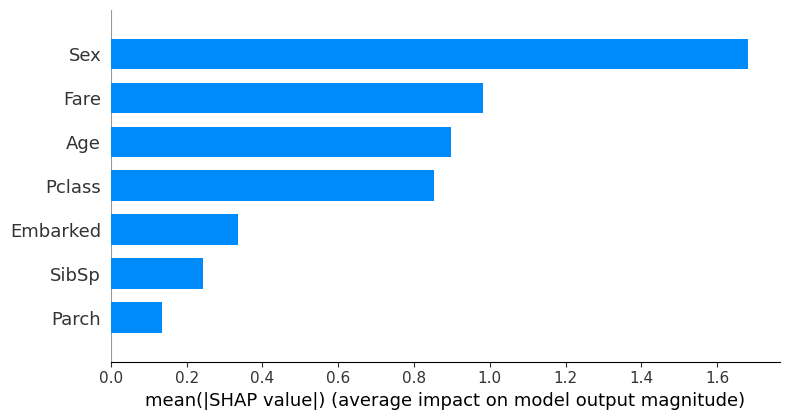

In [27]:
shap_values = shap.TreeExplainer(clf).shap_values(X)
shap.summary_plot(shap_values, X_train, plot_type="bar")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


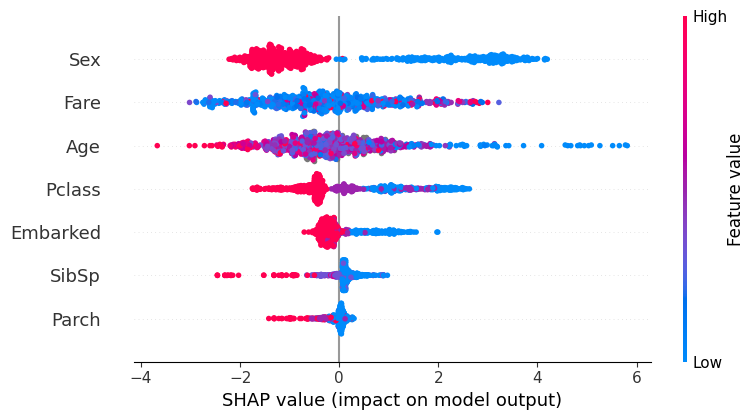

In [11]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

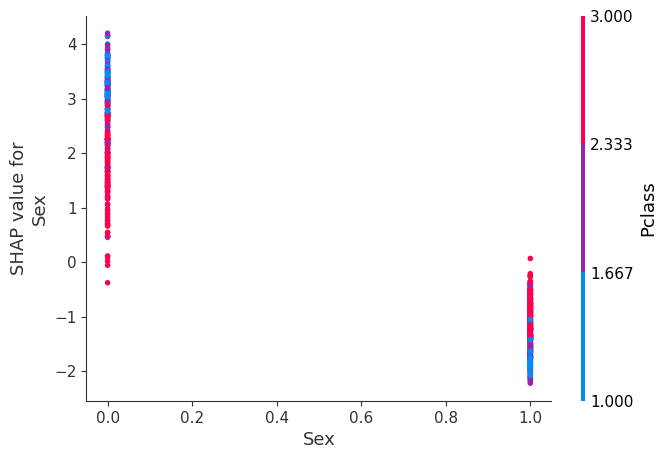

In [29]:
shap.dependence_plot("Sex", shap_values, X)

<h1 style="font-size:60px;"> <center> DEEP LEARNING </center> </h1>

<h1 style="font-size:50px;"> <center> Autokeras </center> </h1>

In [48]:
callback = [
    EarlyStopping(monitor="val_loss", patience=25, mode="min"),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=15,
        verbose=1,
        min_delta=1e-3,
        mode="min",
    ),
]

0.7947761194029851

In [ ]:
search = ak.StructuredDataRegressor(
    max_trials=3,
    project_name="Shell Regressor",
    loss="mean_squared_error",
    overwrite=True,
)
search.fit(
    x=X_train_inner_val,
    y=y_train_inner_val,
    epochs=30,
    verbose=1,
    callbacks=[callback],
    validation_split=0.5,
)

In [ ]:
best_nn_model = search.export_model()
best_nn_model

In [ ]:
with mlflow.start_run(
    experiment_id=experiment.experiment_id,
    run_name="AutoKeras Best Model Full Data Evaluation",
) as run:
    rmsle_scores = []
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    for train_index, val_index in tqdm(
        kf.split(X_outer_val),
        desc="AutoKeras Best Model Full Data Evaluation...",
    ):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        best_nn_model.fit(
            X_train,
            y_train,
            epochs=200,
            verbose=2,
            callbacks=[callback],
            validation_split=0.2,
        )
        y_pred = best_nn_model.predict(X_val)
        y_pred = pd.Series(y_pred.flatten())
        mse_score = mean_squared_error(y_val, y_pred)
        rmsle_scores.append(mse_score)
    print(
        "Ensemble Mean RMSLE Score: {}, STD ofRMSLEMSE Score: {}".format(
            np.mean(rmsle_scores), np.std(rmsle_scores)
        )
    )
    mlflow.log_param(
        "layer number", len(best_nn_model.get_config()["layers"])
    )
    mlflow.log_param(
        "learning rate", K.eval(best_nn_model.optimizer.lr)
    )
    mlflow.log_metric("mse", np.mean(mse_scores))
    mlflow.keras.log_model(best_nn_model, "Autokeras")

<h1 style="font-size:60px;"> <center> FINAL MODELS </center> </h1>

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(
    X_train, y_train, test_size=0.30, random_state=C.RANDOM_SEED
)

<h1 style="font-size:40px;"> <center> Hist GBM </center> </h1>

In [ ]:
clf1 = HistGradientBoostingClassifier(
    random_state=C.RANDOM_SEED, **best_hps["histgbm"]
)
clf1.fit(train_x, train_y)
pred_y1 = clf1.predict(val_x)
score = accuracy_score(val_y, pred_y1)
print(f"Score for HistGBM is {score:0.3f}")

<h1 style="font-size:40px;"> <center> Light GBM </center> </h1>

In [ ]:
clf2 = LGBMClassifier(
    random_state=C.RANDOM_SEED, **best_hps["lightgbm"]
)
clf2.fit(train_x, train_y)
pred_y2 = clf2.predict(val_x)
score = accuracy_score(val_y, pred_y2)
print(f"Score for LightGBM is {score:0.3f}")

<h1 style="font-size:40px;"> <center> XGBoost </center> </h1>

In [ ]:
clf3 = XGBClassifier(
    random_state=C.RANDOM_SEED,
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    eval_metric=C.EVAL_METRIC ** best_hps["xgboost"],
)
clf3.fit(train_x, train_y)
pred_y3 = clf3.predict(val_x)
score = accuracy_score(val_y, pred_y3)
print(f"Score for XGBoost is {score:0.3f}")

<h1 style="font-size:40px;"> <center> CatBoost </center> </h1>

In [ ]:
clf4 = CatBoostClassifier(
    random_state=C.RANDOM_SEED,
    eval_metric="AUC",
    verbose=0,
    **best_hps["catboost"],
)
clf4.fit(train_x, train_y)
pred_y4 = clf4.predict(val_x)
score = accuracy_score(val_y, pred_y4)
print(f"Score for CatBoost is {score:0.3f}")

<h1 style="font-size:60px;"> <center> ENSEMBLING </center> </h1>

<h1 style="font-size:50px;"> <center> Blending </center> </h1>

In [ ]:
preds = np.stack(
    [
        pred_y1,
        pred_y2,
        pred_y3,
        pred_y4,
    ]
)
max_voting = np.apply_along_axis(mode, 1, preds)[:, 0]

In [ ]:
score = accuracy_score(val_y, max_voting)
print(f"Score for Ensemble is {score:0.3f}")

<h1 style="font-size:50px;"> <center> Stacking </center> </h1>

<h1 style="font-size:50px;"> <center> PREDICTION & SUBMISSION </center> </h1>

In [ ]:
y_pred = clf.predict(X_test)
submission = pd.DataFrame(y_pred)
submission.index = X_test.index
submission.to_csv("submission.csv", index=False)
submission.to_csv(
    f"Submission-{time.strftime('%d - %H-%M-%S')}.csv", index=False
)

<h1 style="font-size:50px;"> <center> SHUTDOWN THE KERNEL </center> </h1>

In [ ]:
os.kill(os.getpid(), signal.SIGTERM)